In [58]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
import scipy.stats
from sklearn.decomposition import FastICA, PCA
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.random_projection import GaussianRandomProjection

In [59]:
from data_helpers.wine_quality_data_helper import load_wine_quality_data
from data_helpers.mnist_data_helper import load_mnist_data

In [60]:
class ICAWrapper:
    NAME = 'ICA'
    def __init__(self, n_components) -> None:
        self.model = FastICA(n_components=n_components, max_iter=1000)
    
    def fit(self, X):
        return self.model.fit(X)
    
    def fit_transform(self, X):
        return self.model.fit_transform(X)
    
    def transform(self, X):
        return self.model.transform(X)

class PCAWrapper:
    NAME = 'PCA'
    def __init__(self, n_components) -> None:
        self.model = PCA(n_components=n_components)

    def fit(self, X):
        return self.model.fit(X)

    def fit_transform(self, X):
        return self.model.fit_transform(X)

    def transform(self, X):
        return self.model.transform(X)

class RPWrapper:
    NAME = 'RP'
    def __init__(self, n_components) -> None:
        self.model = GaussianRandomProjection(n_components=n_components)
    
    def fit(self, X):
        return self.model.fit(X)
    
    def fit_transform(self, X):
        return self.model.fit_transform(X)

    def transform(self, X):
        return self.model.transform(X)

    def get_reconstruction_error(self, X):
        X_star = self.model.fit_transform(X)
        X_reconstructed = self.model.inverse_transform(X_star)
        return np.mean(np.square(X - X_reconstructed))
    
class LLEWrapper:
    NAME = 'LLE'
    def __init__(self, n_components) -> None:
        self.model = LocallyLinearEmbedding(n_components=n_components, n_neighbors=10)
    
    def fit(self, X):
        return self.model.fit(X)
    
    def fit_transform(self, X):
        return self.model.fit_transform(X)
    
    def transform(self, X):
        return self.model.transform(X)
    
    def get_reconstruction_error(self):
        return self.model.reconstruction_error_

In [61]:
DATASET_NAME = 'wine_quality'

# METHOD = PCAWrapper
# METHOD = ICAWrapper
# METHOD = RPWrapper
METHOD = LLEWrapper

In [62]:
if DATASET_NAME == 'wine_quality':
    DATASET_STR = 'Wine Quality'
    X, y, _, _ = load_wine_quality_data()
elif DATASET_NAME == 'mnist':
    DATASET_STR = 'MNIST'
    X, y, _, _ = load_mnist_data()
else:
    raise ValueError(f'Invalid dataset name {DATASET_NAME}')

if DATASET_NAME == 'mnist':
    n = 5000
    X = X[:n]
    y = y[:n]

In [63]:
num_components = 2

In [64]:
n = int(X.shape[0] * 0.8)
X_train = X[:n]
y_train = y[:n]
X_test = X[n:]
y_test = y[n:]

In [65]:
X_train.shape

(3134, 11)

In [66]:
model = METHOD(num_components)
X_train_star = model.fit(X_train)

In [67]:
X_test_star = model.transform(X_test)

In [68]:
import matplotlib.pyplot as plt

In [69]:
X_test_star.shape

(784, 2)

In [70]:
X_test_star

array([[-0.0040257 , -0.00486234],
       [ 0.0342365 ,  0.00927774],
       [ 0.00776607, -0.02189366],
       ...,
       [-0.00070723,  0.01668302],
       [ 0.01786268,  0.0041994 ],
       [ 0.00188393,  0.01002051]])

In [71]:
C1 = np.array([1, 1, 0])
C2 = np.array([1, 0, 0])
LABELS = [3, 4, 5, 6, 7, 8, 9]
COLORS = {}
for i, label in enumerate(LABELS):
    COLORS[label] = C1 + i * (C2 - C1) / len(LABELS)

/Users/sdale/repos/gatech/machine_learning/unsupervised_learning/final_results/step_2/lle_wine_quality_2d.png


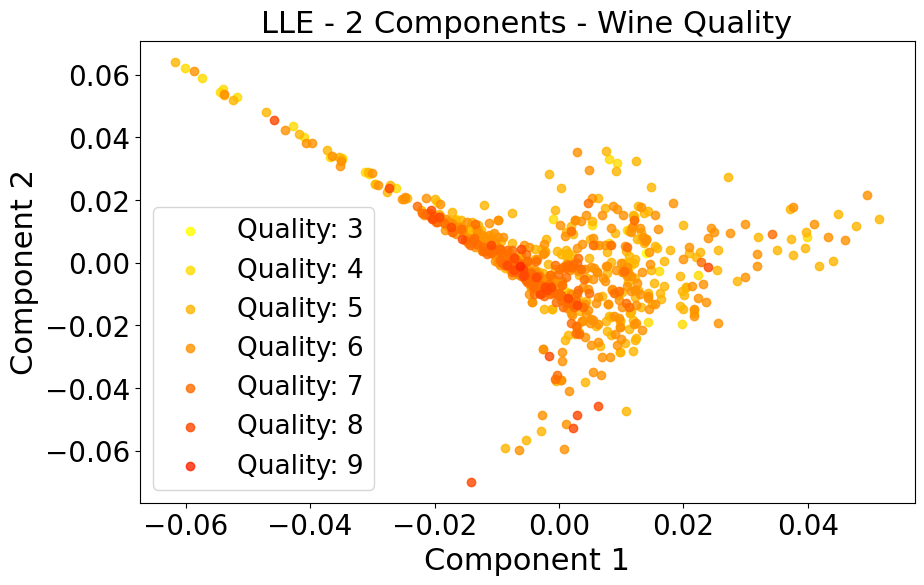

In [74]:
fontsize = 22
plt.figure(figsize=(10, 6))

A = 0.8
for label in sorted(np.unique(y_test)):
    X_label = X_test_star[y_test == label]
    plt.scatter(X_label[:, 0], X_label[:, 1], label=f'Quality: {label}', color=COLORS[label], alpha=A)

plt.title(f'{METHOD.NAME} - 2 Components - {DATASET_STR}', fontsize=fontsize)
plt.xlabel('Component 1', fontsize=fontsize)
plt.ylabel('Component 2', fontsize=fontsize)
plt.legend(fontsize=fontsize-3)

plt.xticks(fontsize=fontsize-2)
plt.yticks(fontsize=fontsize-2)

# plt.xlim(-3.2, 4.2)

path = (f'/Users/sdale/repos/gatech/machine_learning/unsupervised_learning/final_results/step_2/'+
        f'{METHOD.NAME.lower()}_{DATASET_NAME.lower()}_2d.png')
print(path)
os.makedirs(os.path.dirname(path), exist_ok=True)
plt.savefig(path, bbox_inches='tight')